In [1]:
import pandas as pd
import numpy as np

import torch

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
data_path = "./data/train.csv"

In [3]:
data = pd.read_csv(data_path, parse_dates = ["date_time"])

data['num'] = data['num'].apply(str)

data["time_idx"] = 0
data["month"] = 0

data.loc[data["date_time"].dt.month == 6, 'month'] = 0
data.loc[data["date_time"].dt.month == 7, 'month'] = 30
data.loc[data["date_time"].dt.month == 8, 'month'] = 61

data["time_idx"] = data["date_time"].dt.hour + data["date_time"].dt.day * (24) + data["month"] * 24
data["time_idx"] = data["time_idx"] - min(data["time_idx"])
data = data.drop("month",axis='columns')

data.rename(columns = {'전력사용량(kWh)' : 'kWH', '기온(°C)' : 'C', '풍속(m/s)' : 'm/s', '습도(%)' : 'wet', '강수량(mm)' : 'mm','일조(hr)' : 'hr', '비전기냉방설비운영' : "non_electric_aircondition", "태양광보유" : "sunlight"}, inplace = True)

data = data.astype({'non_electric_aircondition' : int, 'sunlight' : int})

data.to_csv("test.csv", mode='w')

data.head()

num           date_time       kWH     C  m/s   wet   mm   hr  \
0   1 2020-06-01 00:00:00  8179.056  17.6  2.5  92.0  0.8  0.0   
1   1 2020-06-01 01:00:00  8135.640  17.7  2.9  91.0  0.3  0.0   
2   1 2020-06-01 02:00:00  8107.128  17.5  3.2  91.0  0.0  0.0   
3   1 2020-06-01 03:00:00  8048.808  17.1  3.2  91.0  0.0  0.0   
4   1 2020-06-01 04:00:00  8043.624  17.0  3.3  92.0  0.0  0.0   

   non_electric_aircondition  sunlight  time_idx  
0                          0         0         0  
1                          0         0         1  
2                          0         0         2  
3                          0         0         3  
4                          0         0         4

In [4]:
max_prediction_length = 6
max_encoder_length = 48
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="kWH",
    group_ids=["num"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=3,
    max_prediction_length=max_prediction_length,
    static_categoricals=["num"],
    static_reals=["non_electric_aircondition", "sunlight"],
    # time_varying_known_categoricals=["month"],
    time_varying_known_reals=["C", "m/s", "wet", "mm", "hr", "time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["kWH"],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=12)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=1)

In [5]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=30, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=32, 
    callbacks=[lr_logger],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=0,
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Number of parameters in network: 74.3k


In [6]:
# fit network
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 960   
3  | prescalers                         | ModuleDict                      | 208   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm 

/home/joeunchan/anaconda3/envs/torch1/lib/python3.9/site-packages/pytorch_forecasting/models/base_model.py:663: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


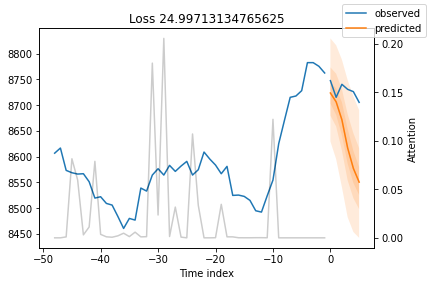

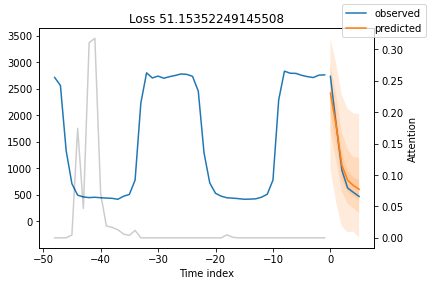

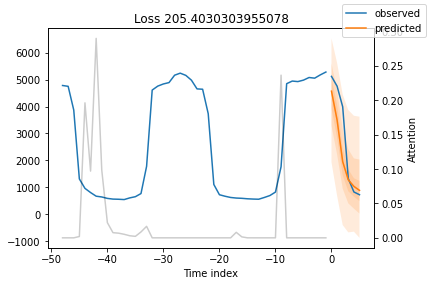

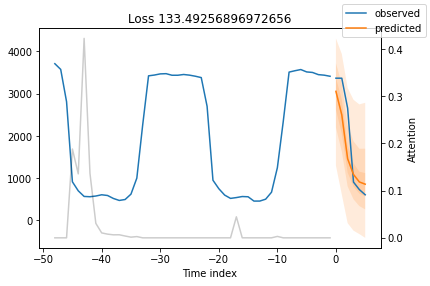

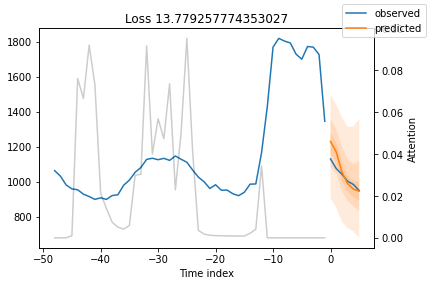

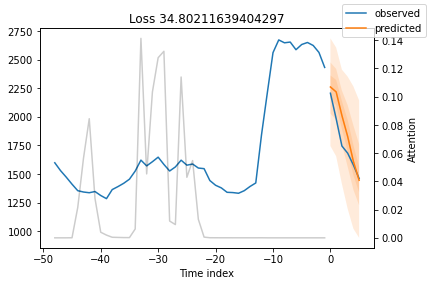

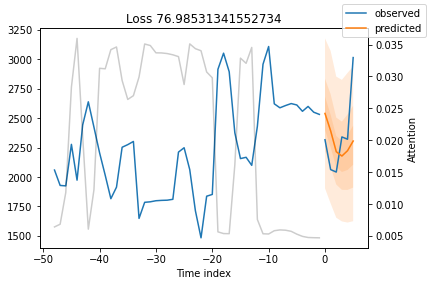

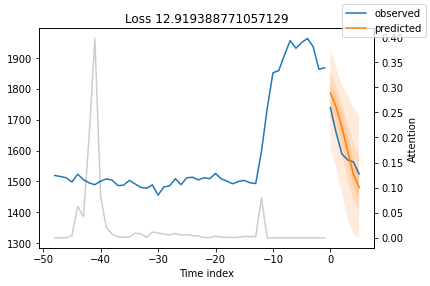

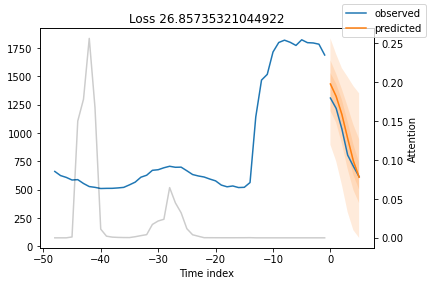

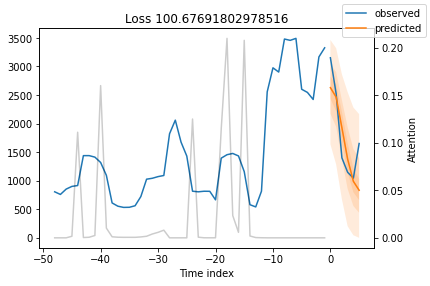

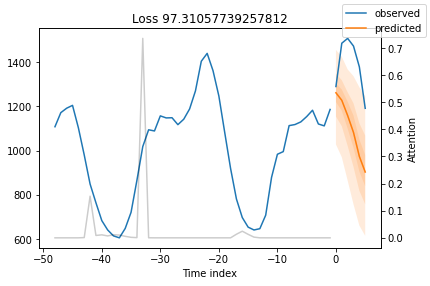

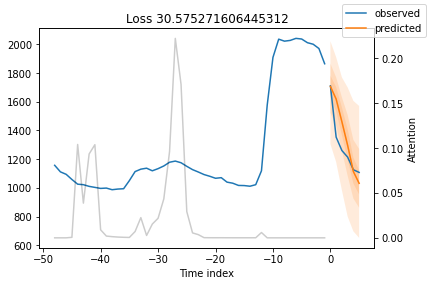

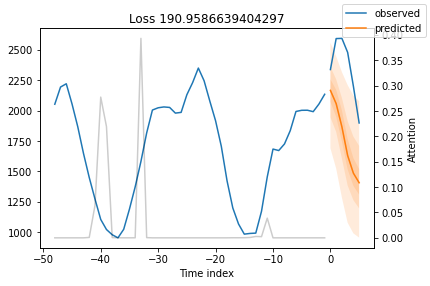

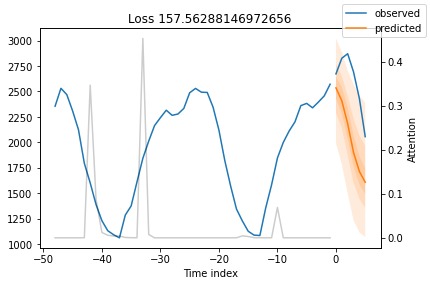

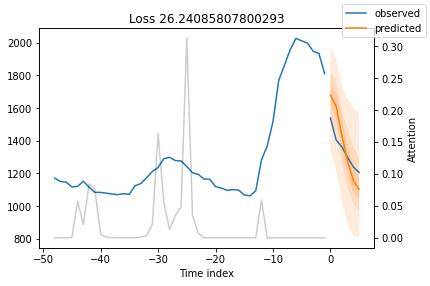

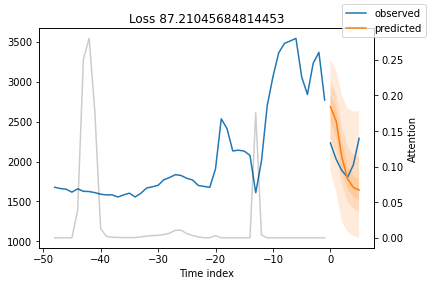

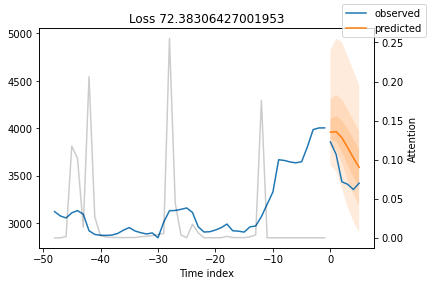

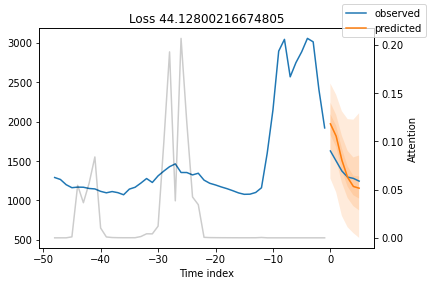

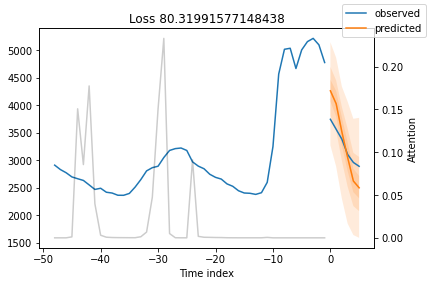

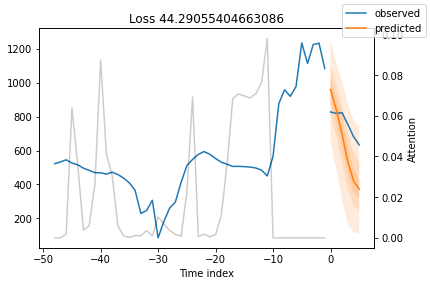

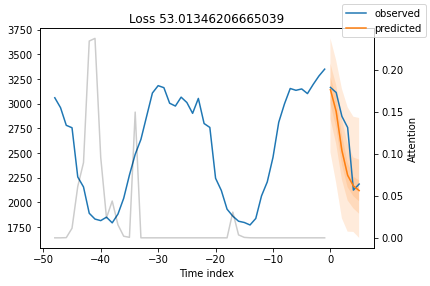

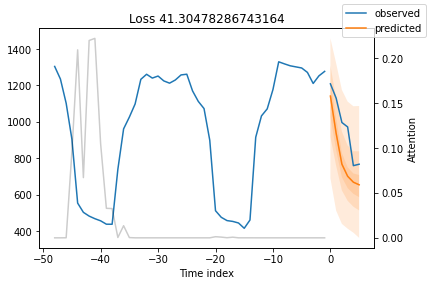

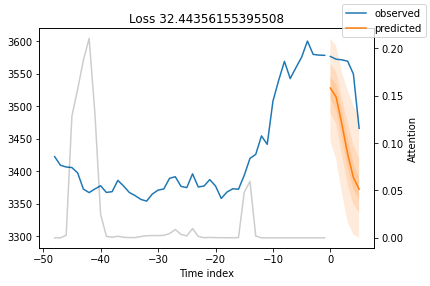

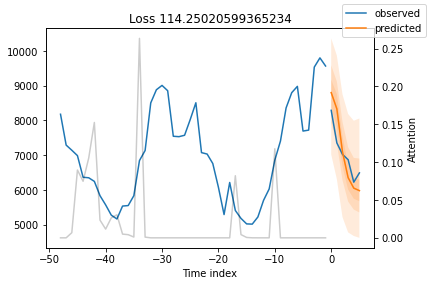

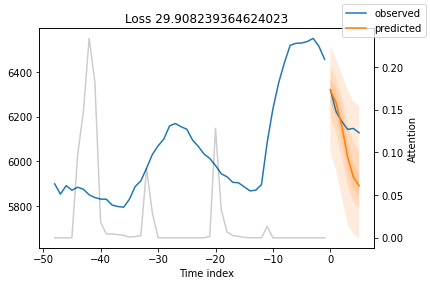

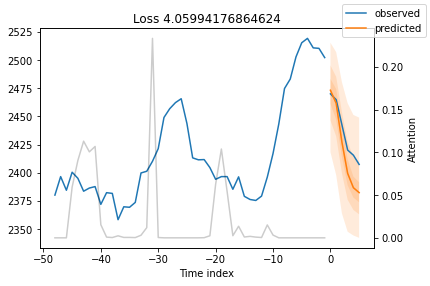

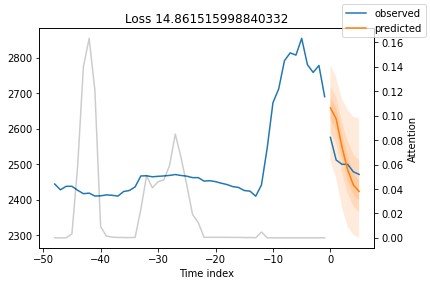

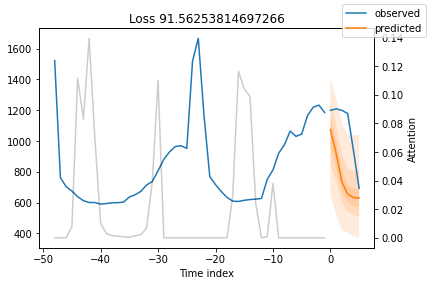

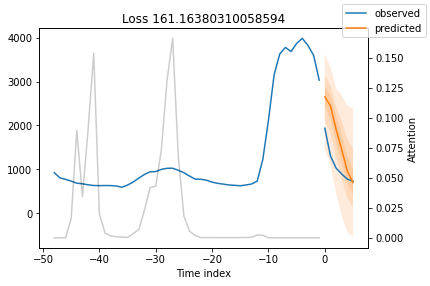

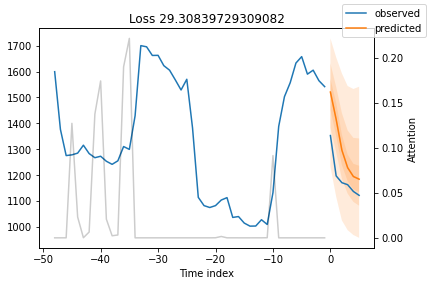

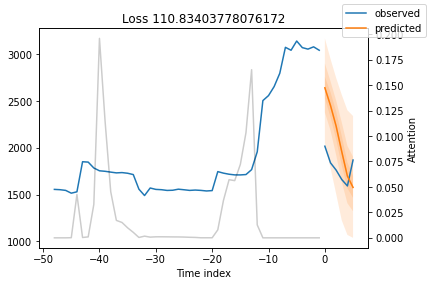

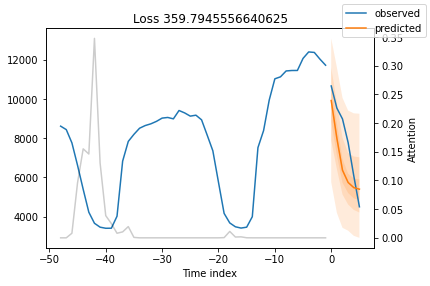

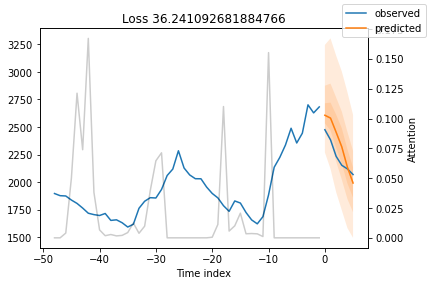

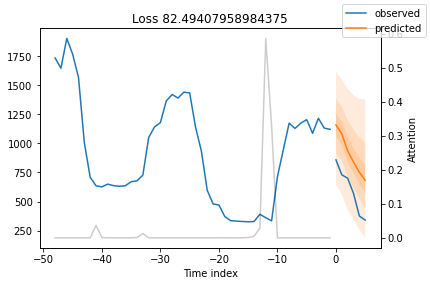

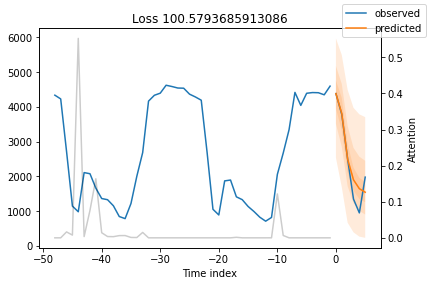

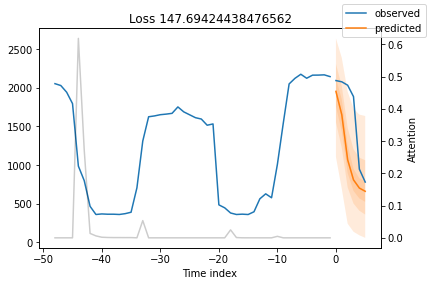

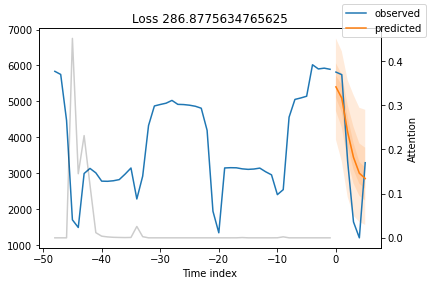

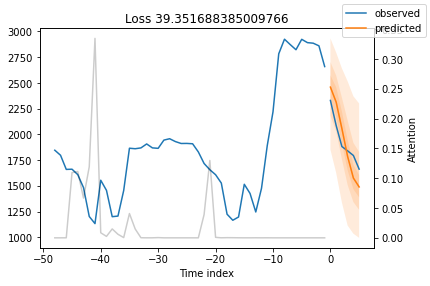

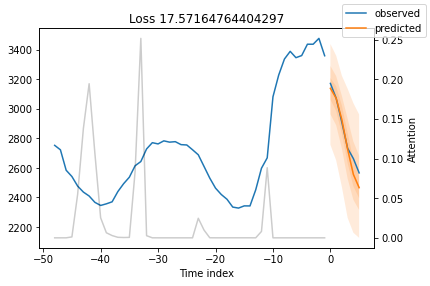

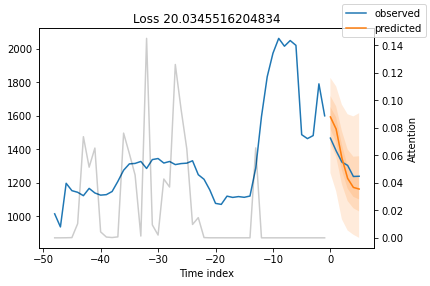

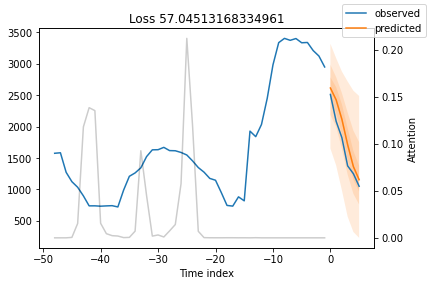

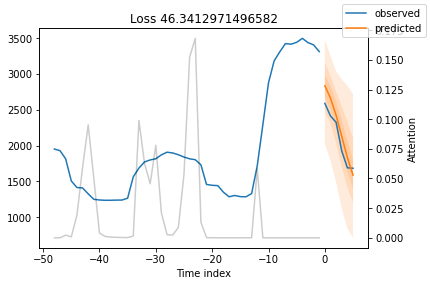

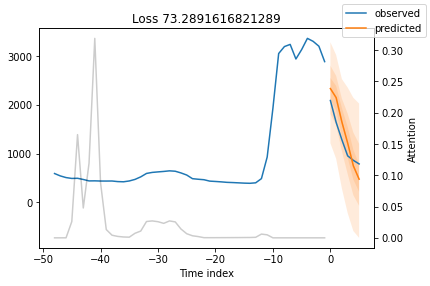

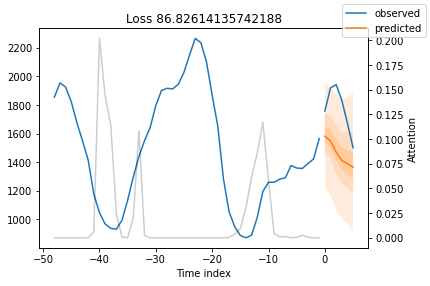

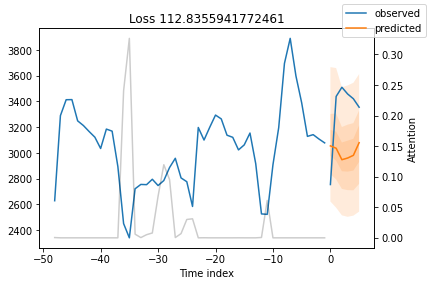

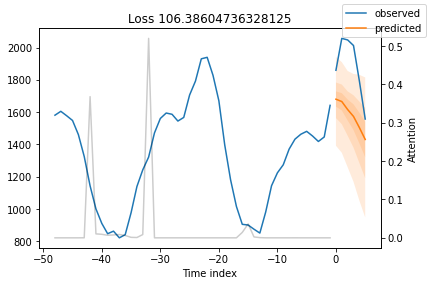

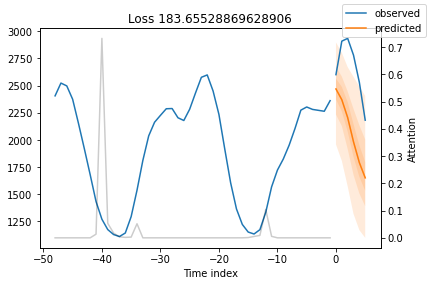

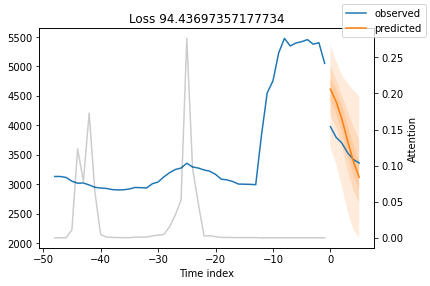

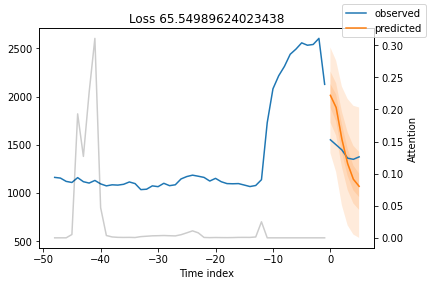

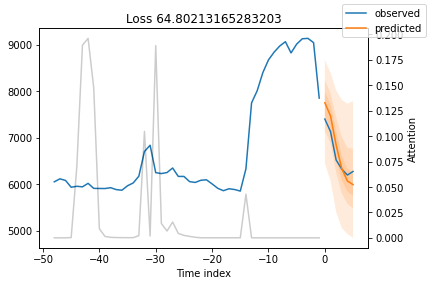

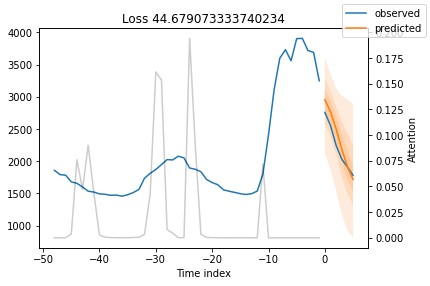

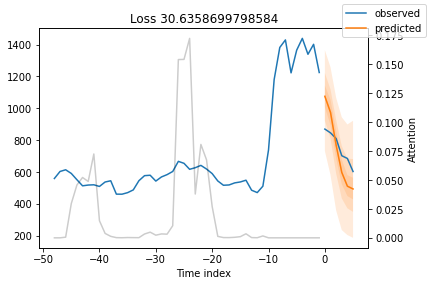

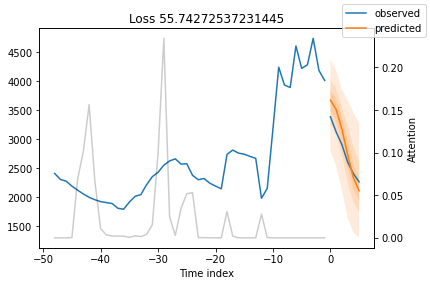

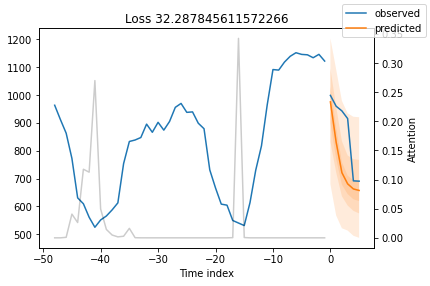

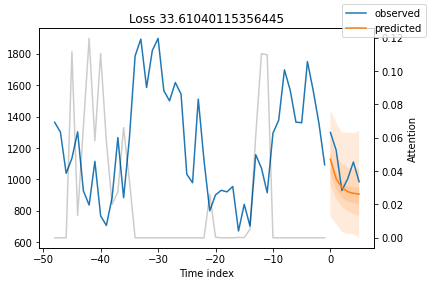

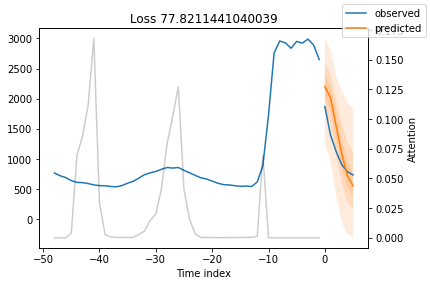

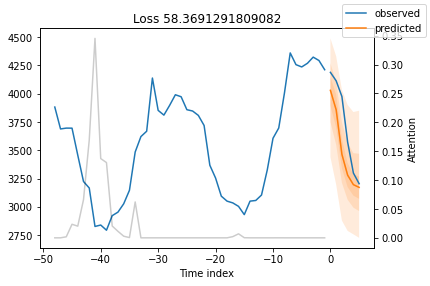

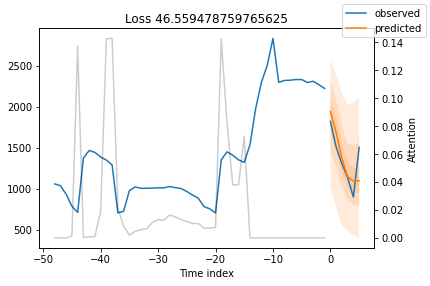

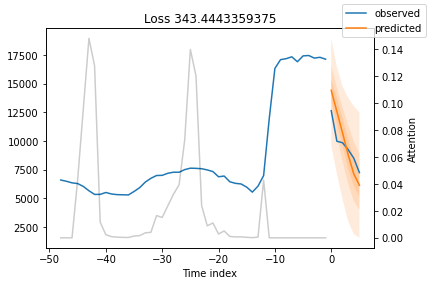

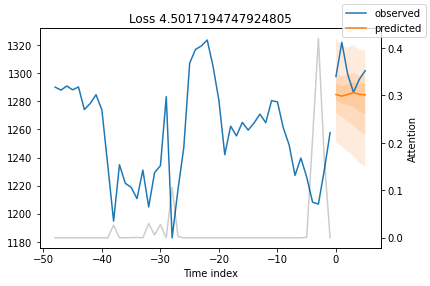

In [7]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

for idx in range(60):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)